<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint6/Module4/JDS_SHR_224_guided_project_notes_TanzaniaWaterPumpCaseStudyConfusionMatrixPrecisionRecallClassificationThresholdsPredictedProbailities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [1]:
%%capture
!pip install category_encoders==2.*

In [2]:
import sklearn

In [3]:
print(sklearn.__version__)

1.3.2


In [33]:
pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
from sklearn.metrics import ConfusionMatrixDisplay
# use this instead of plot_confusion_matrix which is now defunct

In [3]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [ ]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# List all files in your Kaggle folder on your google drive.
!ls

sample_submission.csv  test_features.csv  train_features.csv  train_labels.csv


# I. Wrangle Data

In [4]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')

    # Or I can place this line here while we're reading the training set data
    # df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # use the where function, if it's functional then it's a 0, otherwise a 1
    # df.drop(columns='status_group', inplace=True) # after we create the new column 'needs_repair' using 'status_group', we have to drop 'status_group' to avoid data leakage
  else:

    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')


  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index   # using LIST COMPREHENSION aka creating a new list by iterating through an existing iterable data structure, e.g.
              if df.head(100).T.duplicated()[col]]                # here we create a list of duplicate columns by iterating through all the columns in the dataframe
  df.drop(columns=dupe_cols, inplace=True)

  # Change multi-class classification problem to a binary classification
  if 'status_group' in df:
    df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # use the where function, if it's functional then it's a 0, otherwise a 1
    # if you don't put the if statement, this line will try to wrangle both our training AND test set which in the test set doesn't have the column status_group,
    # so we only apply this line of code if we have the status_group column, which in our case will be the training set
    df.drop(columns='status_group', inplace=True) # after we create the new column 'needs_repair' using 'status_group', we have to drop 'status_group' to avoid data leakage

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

## EDA


In [4]:
df.shape, X_test.shape

((47519, 31), (11880, 30))

Today we're converting our multiclass classification (3 classes) into binary (2 classes) as we're combining non-functional pumps with functional but need repair pumps.

In [ ]:
# Classify into pumps that need repair and pumps that do not need repairs.
# functional - class 0
# non functional, functional needs repair - class 1

In [5]:
# OPTION 1
df['needs_repair'] = np.where(df['status_group']=='functional',0,1) # use the where function, if it's functional then it's a 0, otherwise a 1

In [ ]:
# # OPTION 2
# df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
# # if the the statement of "not functional" is true, returns a boolean value True, and cast it as an integer, which is 1

In [ ]:
# # OPTION 3
# df['needs_repair'] = df['status_group'].apply(lambda x: 0 if x=='functional' else 1)
# # x is a bound variable. lambda function generally one line expression

In [8]:
df['needs_repair'].unique()

array([0, 1])

# II. Split Data

In [5]:
# Split TV / FM
target = 'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [17]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model


In [6]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                        random_state=42))])

# Interlude: Beware or Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**.

<Axes: >

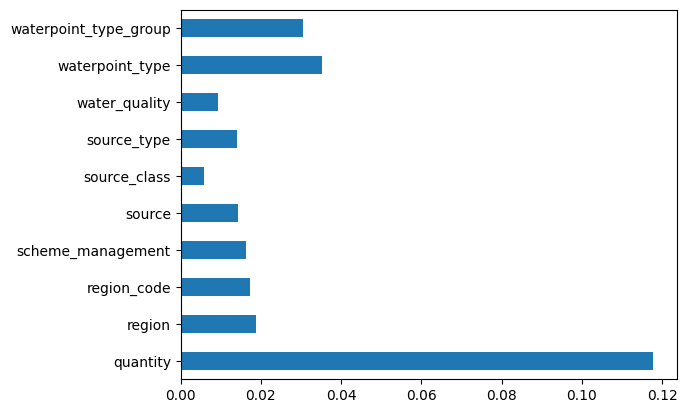

In [19]:
# let's plot our feature importances
importances = model.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns # get column names
pd.Series(importances, index=features).sort_index().tail(10).plot(kind='barh')

In [ ]:
# before we delete the 'status_group' column, status_group column is the most important feature out there???? we should have deleted the status group because those contain the answers
# we drop the column in the wrangle function, rerun everything and now the feature importance bar graph makes much more sense

# Check Metrics

**Accuracy Score**

In [13]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.9997895622895623


In [ ]:
# when we see a perfect score, we'll have to be careful. Something is wrong. Looks like our model is cheating and knows the answers from data leakage. Scroll up to see solution

In [ ]:
# we dropped the status_group column and reran everything, now the accuracy score is lower and is more realistic

In [20]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993660397211627
Validation Accuracy: 0.8055555555555556


Accuracy score sometimes is not a dependable metric. Consider this typical example of imbalanced dataset, about spam email filter:

In [ ]:
# total 10000 emails
# class 0 - 9900 - not spam
# class 1 - 100 - spam

# If my filter classifies everything as non-spam, I'll still get 9900/10000 as accuracy score, which is 99%!

Accuracy is NOT a good way to measure model performace if working with an imbalanced dataset. Othere examples include:
- medical diagnosis
- credit card fraud
- spam email

**Confusion Matrix**

- useful to identify patterns of misclassification
- Predicted labels - precision - positive calls - P has a C in it, Columns
- Truth - Recall - Rows

- Type I error (alpha) - False Positive - when you reject the null hypothesis as false (positive change) when it's actually true, e.g. concluding a new drug is effective when it has no actual effect.
- safer to have more false positives than negatives if we're predicting whether a patient has a disease or not.
- Type II error (beta) - False Negative - when you fail to reject the null hypothesis as true (no significant change) when it's actually false, e.g. failing to recognize the new drug is effective when it does work
- need to focus on reducing false negatives than positives if we're predicting whether an airline is overbooking because overbooking is more costly than empty seats on the plane

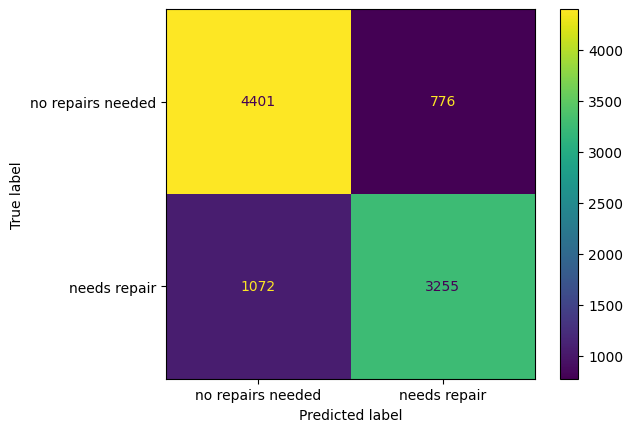

In [19]:
# plot_confusion_matrix is outdated, we will have to use this instead
ConfusionMatrixDisplay.from_estimator(
    model,
    X_val,
    y_val,
    values_format='.0f',  # no scientific notation
    display_labels=['no repairs needed', 'needs repair']) # displays classes in sorted order, 0 means no repairs needed and 1 means repair needed
    # what's this???? --> ConfusionMatrixDisplay.from_estimator
    # we are evaluating our model with validation data set, something the model hasn't seen before! And it also needs to have the true labels in it. so we can't use the
    # training set and we can't use the test set without labels

Remember: function is 0, needs repair is 1.

**Accuracy Score**
- (True Pos + True Neg) / Everything =

In [10]:
(4401 + 3255) / (1072 + 3255 + 4401 + 776)
# it matches our previous validation accuracy score!

0.8055555555555556

**Precision Score**

Of all the pumps that you predicted as needing repair (All positive calls), what proportion actually needed repair (True positive)?

In [ ]:
# precision = tp / (tp + fp)

In [11]:
3255 / (3255+776)

0.8074919374844952

**Recall Score**

Of those pumps that actually needed repair (True Positive and False Negative), what proportion did you correctly predict as needing repair (True Positive)?

In [ ]:
# recall tp / (tp + fn)

In [12]:
3255 / (3255 + 1072)

0.7522532932747862

**Classification Report**
- don't need to do it by hand
- it shows us all the scores

In [14]:
classification_report(y_val,
                      model.predict(X_val),
                      target_names=['no repairs needed', 'repairs needed'])



'                   precision    recall  f1-score   support\n\nno repairs needed       0.80      0.85      0.83      5177\n   repairs needed       0.81      0.75      0.78      4327\n\n         accuracy                           0.81      9504\n        macro avg       0.81      0.80      0.80      9504\n     weighted avg       0.81      0.81      0.80      9504\n'

In [15]:
# it would look like that if you don't put it in a print statement so let's do this:
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names=['no repairs needed', 'repairs needed']))

                   precision    recall  f1-score   support

no repairs needed       0.80      0.85      0.83      5177
   repairs needed       0.81      0.75      0.78      4327

         accuracy                           0.81      9504
        macro avg       0.81      0.80      0.80      9504
     weighted avg       0.81      0.81      0.80      9504



**F-score**
- F1-score is a harmonic mean of precision and recall
- F-score = 2 * (precision * recall) / (precision + recall)
- in cases where both precision and recall are important, we wanna maximize our F-score

**The balance between precision and recall**
- Some cases higher recall is better than low precision e.g. medical diagnosis. We care about how our true positive calls compare to the truth, not how they compare to all our positive calls. We need to reduce number of False Negatives.

- For YouTube recommendations, the precision matters more.
- water pump example: High recall gives priority to people who need access of water (reduce FN, water pumps that actually need repair but missed). High precision gives priority to reducing unnecessary costs (reduce FP, water pumps that actually don't need repair but we go and repair them anyway).
- At the end, it's the balance of profits and doing good.

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections.

In [17]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [18]:
# no model, strictly based on ratio of functional and non-functional, like our baseline
y_val.value_counts(normalize=True)

0    0.544718
1    0.455282
Name: needs_repair, dtype: float64

In [21]:
repair_prob = y_val.value_counts(normalize=True).min()
repair_prob

0.45528198653198654

In [25]:

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(n_inspections * repair_prob))
print('Funds wasted:', (int(n_inspections - n_inspections * repair_prob) * 100))
       # inspected pumps - pumps repaired are the pump inspections wasted, each pump inspection costs $100
       # we need int because pump is a whole number

Inspections conducted: 2000
Pumps repaired: 910
Funds wasted: 108900


In [26]:
# If we choose pumps randomly, we could only repair less than half of the pumps, and we're losing more than half of the budget! That's not acceptable.

Scenario 2: Using our random forest model "out of the box"

In [27]:
# create a dictionary and then convert it to a dataframe
data = {
    'y_val':y_val,
    'y_pred': model.predict(X_val)
}

results =pd.DataFrame(data)

In [31]:
results.head()

,y_val,y_pred
id,,
8492.0,1,0
16772.0,1,1
19506.0,0,1
40301.0,1,1
61519.0,0,0


In [28]:
# create a mask to filter out only those pumps which my model thinks repair is necessary
mask = (results['y_pred']==1)
sample = results[mask].sample(n_inspections) # out of all the ones I predicted needing repair, which is > 10K, but I only have budget for 2000 pumps, so I need to take a sample

In [29]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(sample['y_val'].sum())) # sum of the actual values column in the sample dataframe where all the predictions say repair needed, see how many match
print('Funds wasted:', int((n_inspections - sample['y_val'].sum()))*100)

Inspections conducted: 2000
Pumps repaired: 1607
Funds wasted: 39300


In [30]:
# WOW! HUGE IMPROVEMENT IN FUNDS WASTED!

Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.
- raising the threshold to consider a pump needs repair from 0.5 to 0.85, so more pumps inspected & repaired are actual broken pumps.
- lower threshold favors recall and places priority on people having access to water

- To increase the threshold, we need to increase the prediction probabilities, not the predictions themselves
- but decision trees don't have classification thresholds, unlike logistic regression
- The prediction probability, or the predict_proba method will give you the proportion of trees in the ensemble
- Ensemble = grouping or cluster of weak learners to create a strong learner




In [32]:
model.predict_proba(X_val)

array([[0.76, 0.24],
       [0.  , 1.  ],
       [0.04, 0.96],
       ...,
       [0.08, 0.92],
       [0.44, 0.56],
       [0.24, 0.76]])

In [33]:
data = {
    'y_val':y_val,
    'y_pred_proba':model.predict_proba(X_val)[:,-1], # grab the very last column only, probability values ONLY for the positive class where it's 1
}

results =pd.DataFrame(data)

In [35]:
threshold = 0.85

In [37]:
mask = (results['y_pred_proba'] > threshold)
sample = results[mask].sample(n_inspections) # same concept as scenario 2

In [38]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(sample['y_val'].sum()))
print('Funds wasted:', int(n_inspections - sample['y_val'].sum())*100)
# wasted even less money because we're more aggressive with saving money and increasing precision

Inspections conducted: 2000
Pumps repaired: 1896
Funds wasted: 10400
